<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\G\AppData\Local\Temp\ipykernel_26472\3726421622.py:3: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv("data\gfp_ground_truth.csv")


                                            sequence     score
0  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.718386
1  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.622869
2  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.722241
3  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.697823
4  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.804003
              score
count  56086.000000
mean       2.731658
std        1.052256
min        1.283419
25%        1.466385
50%        3.377876
75%        3.635888
max        4.123109
sequence    0
score       0
dtype: int64


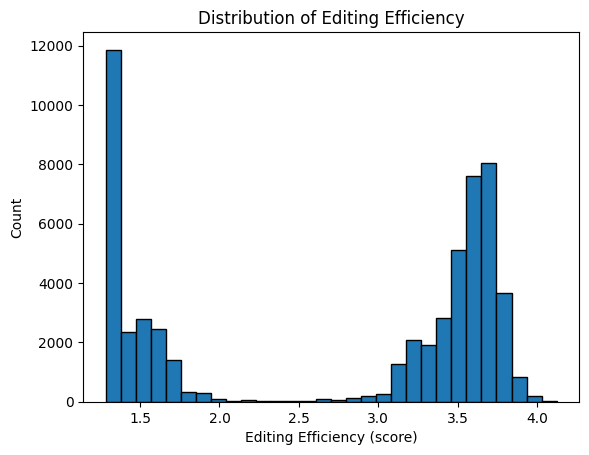

In [3]:
import pandas as pd

df = pd.read_csv("data\gfp_ground_truth.csv")


print(df.head())


print(df.describe())


print(df.isnull().sum())
import matplotlib.pyplot as plt

plt.hist(df["score"], bins=30, edgecolor="black")
plt.xlabel("Editing Efficiency (score)")
plt.ylabel("Count")
plt.title("Distribution of Editing Efficiency")
plt.show()

In [4]:
import numpy as np

AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}

def one_hot_encode(seq, max_len):
    encoding = np.zeros((max_len, len(AMINO_ACIDS)), dtype=np.float32)
    for i, aa in enumerate(seq):
        if i >= max_len:
            break
        if aa in aa_to_idx:
            encoding[i, aa_to_idx[aa]] = 1.0
    return encoding

def embed_sequences_onehot(sequences):
    max_len = max(len(s) for s in sequences)
    embeddings = []
    for seq in sequences:
        oh = one_hot_encode(seq, max_len)
        mean_pooled = oh.mean(axis=0)
        embeddings.append(mean_pooled)
    return np.vstack(embeddings)


import pandas as pd

df = pd.read_csv("data\gfp_ground_truth.csv")
sequences = df["sequence"].tolist()
y = df["score"].values

X = embed_sequences_onehot(sequences)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


<>:27: SyntaxWarning: invalid escape sequence '\g'
<>:27: SyntaxWarning: invalid escape sequence '\g'
C:\Users\G\AppData\Local\Temp\ipykernel_26472\824234751.py:27: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv("data\gfp_ground_truth.csv")


XGBoost:
  R² = 0.459, MSE = 0.0118
MLP:
  R² = 0.118, MSE = 0.0192


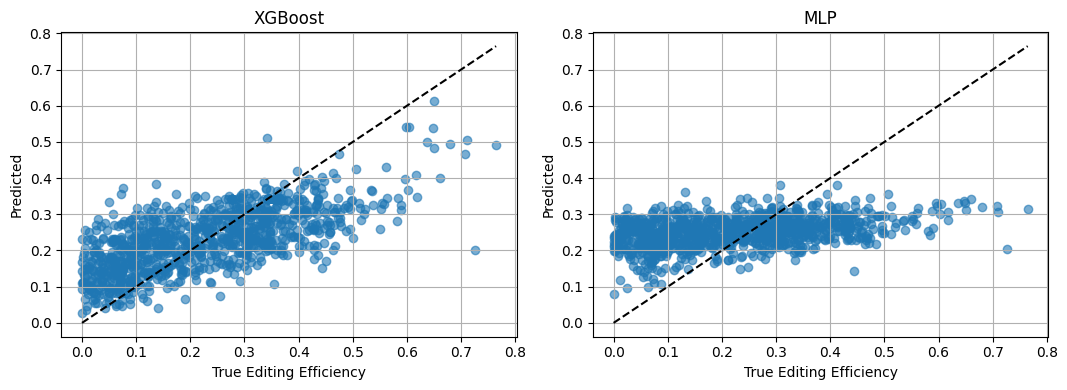

In [10]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}:\n  R² = {r2:.3f}, MSE = {mse:.4f}")
    return y_pred

models = {
    # "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
     "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=1000, random_state=42)
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, name)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
for i, (name, y_pred) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel("True Editing Efficiency")
    plt.ylabel("Predicted")
    plt.title(name)
    plt.grid(True)

plt.tight_layout()
plt.show()
